# Astrometry (WIP)

Lets study and implement an alternative to [astrometry.net](https://astrometry.net) in pure-python. There is an implementation currently available called [twirl](https://github.com/lgrcia/twirl), that uses the same algorithms, but is pure-python. However, this implementation seems to fail on our tests, probably due to not use gnomonic tangencial projection for the catalog.

## Astrometry.net Algorithm

Astrometry.net algorithm, described by [Lang et. al. (2010)](https://ui.adsabs.harvard.edu/abs/2010AJ....139.1782L) uses asterism matching between quads in a catalog and quads in the image that will be solved.

These quads are organized in a way that the most distant stars form a primary diagonal of a ortogonal xy axis and one of the stars ($A$) correspond to coordinate $(0, 0)$ and the other ($B$) correspond to coordinate $(1, 1)$. With these axis defined, the other two stars ($C$ and $D$) are projected in the axis and their x and y coordinates form a quad *hash*, defined and $[Cx, Cy, Dx, Dy]$. A good quad, acoording Lang, respect the following rules:
- $C_x <= D_x$
- $C_x+D_x <= 1$
- All stars must be contained in a circle with radius $\sqrt{2}/2$ and centered in the middle point between A and B.

These quads are generated in image and catalog stars. After the creation, a KD-Tree is created for the catalog quads hashes. The maching is performed using quering the closest neighbor of a quad from the image in the KD-Tree.

With a good match, all image stars are transformed and matched to the catalog. If the percentage of stars that match the catalog is bellow a tolerance, the operation is repeated with another quad.

With the stars matched in the catalog, the $(x, y)$ pixels are related to their correspondent $(ra, dec)$ world coordinates and a WCS is fitted.

## Our Approach

We want to be able to:
- Operate online (downloading catalogs from server) or offline (using astrometry.net local indexes? or local downloaded simplified catalog).
- Use proper motions to fix the positions of the stars to dates.
- Handle flipped images. When an quad has its coordinates flipped horizontally (or vertically), the $x$ and $y$ local coordinates of the hash are flipped for each star.
- ...?

In [1]:
from astropy.io import fits
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
from astropop.photometry import starfind
from astropop.logger import logger
logger.setLevel('DEBUG')
%matplotlib notebook

In [5]:
data = fits.getdata('/home/julio/astropop-tutorial/photometry-example/reduced/HD5980_V_0.fits')
center = SkyCoord('00h59m56s -72d09m53s')
center = [center.ra.value, center.dec.value]
fov = 1.0  # degree

2022-03-26 11:21:27,713 astropop - DEBUG - Relative error computed from FWHM: 1.193839  [detection]
2022-03-26 11:21:27,723 astropop - DEBUG - Found 1438 pixels above threshold  [detection]
2022-03-26 11:21:27,724 astropop - DEBUG - 189 localmaxima located above threshold.  [detection]
2022-03-26 11:21:27,753 astropop - DEBUG - merging 186 close stars in 186 sources  [detection]
2022-03-26 11:21:27,756 astropop - DEBUG - merging 186 close stars in 186 sources  [detection]
2022-03-26 11:21:27,756 astropop - DEBUG - 1 sources rejected by sharpness  [detection]
2022-03-26 11:21:27,757 astropop - DEBUG - 6 sources rejected by roundness  [detection]
2022-03-26 11:21:27,757 astropop - DEBUG - 0 sources rejected by invalid centroid  [detection]


<IPython.core.display.Javascript object>


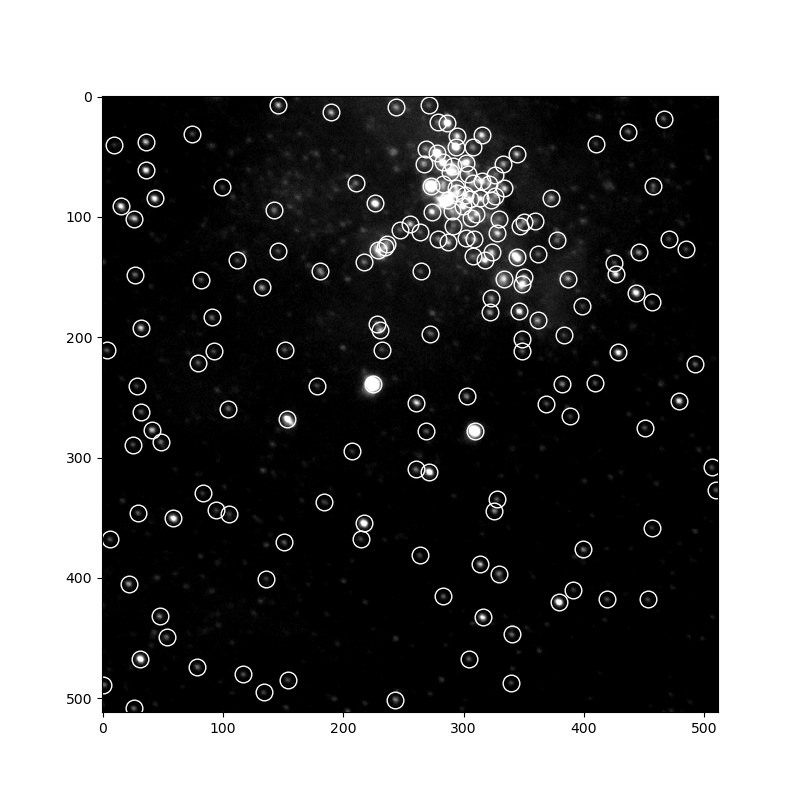

In [6]:
med = np.median(data)
hd5980 = starfind(data, threshold=1, background=med, noise=np.std(data))
plt.figure(figsize=(8,8))
plt.imshow(data, cmap="Greys_r", vmax=np.std(data)*5 + med, vmin=med)
plt.plot(hd5980['x'], hd5980['y'], "o", fillstyle="none", c="w", ms=12)

## Implementation

In [2]:
import numpy as np
from itertools import combinations


SQRT_TWO_OVER_TWO = np.sqrt(2)/2
SQRT_TWO = np.sqrt(2)


def _total_combinations(n, k):
    """Compute the total number of combinations."""
    def _fac(x):
        return np.prod(np.arange(2, x+1), dtype='f16')
    return int(_fac(n)/(_fac(k)*_fac(n-k)))


# rotation matrixes
rot_mat_p = [[SQRT_TWO_OVER_TWO, -SQRT_TWO_OVER_TWO],
             [SQRT_TWO_OVER_TWO, SQRT_TWO_OVER_TWO]]
rot_mat_m = [[SQRT_TWO_OVER_TWO, SQRT_TWO_OVER_TWO],
             [-SQRT_TWO_OVER_TWO, SQRT_TWO_OVER_TWO]]


def _get_axis(a, b):
    """Get the quad-defined xy axis."""
    vec = b - a
    norm = np.hypot(*vec)
    x = -np.cross(vec, rot_mat_p)/norm
    y = np.cross(vec, rot_mat_m)/norm
    
    # unitary x,y vectors
    return x, y


def _hash_quad(a, b, c, d):
    """Compute the quad hash."""
    # get x,y axis and project normalized c and d in the axis
    axis = _get_axis(a, b)
    # b has normalized coordinates 1, so axis have lenght sqrt(2)/2
    norm = np.hypot(*(b-a))/SQRT_TWO

    c_proj = (c-a)/norm
    c_proj = np.dot(c_proj, axis[0]), np.dot(c_proj, axis[1])
    d_proj = (d-a)/norm
    d_proj = np.dot(d_proj, axis[0]), np.dot(d_proj, axis[1])
    return np.array([*c_proj, *d_proj])


def _break_quad_symetry(quad_indx, quad_hash):
    """Check the quad and tries to flip if necessary."""
    # this needs flipping a and b
    if quad_hash[0]+quad_hash[2] > 1:
        # quad[:2] = [quad[1], quad[0]]
        quad_indx[:2] = [quad_indx[1], quad_indx[0]]
        # new = 1 - old
        quad_hash = 1-quad_hash
    
    # this needs to flip c and d
    if quad_hash[0] > quad_hash[2]:
        # quad[2:] = [quad[3], quad[2]]
        quad_indx[2:] = [quad_indx[3], quad_indx[2]]
        # just invert the order
        quad_hash = np.array([*quad_hash[2:], *quad_hash[:2]])
    
    # TODO: it looks like all quads get out of here good
    return quad_indx, quad_hash


def _make_quad(stars, indx):
    """Make a single quad using Lang 2010 convention."""
    indx = np.array(indx)
    s = stars[indx]

    # compute the distance between each pair of srcs
    ds = np.linalg.norm(s[:, :, None] - s.T[None, :, :], axis=1)
    # find the first star of the most distant pair
    # the first index is star a and second is star b
    max_dist = np.max(ds)
    ai, bi = np.unravel_index(np.argmax(ds), ds.shape)
    a, b = s[[ai, bi]]
    ai, bi = indx[[ai, bi]]

    ci, di = [i for i in indx if i not in (ai, bi)]
    c, d = stars[[ci, di]]
    center = (a+b)/2
    r = np.hypot(*(b-a))/2
    if np.abs(np.hypot(*(c-center))) > r or np.abs(np.hypot(*(d-center))) > r:
        # logger.debug('quad (%f,%f) (%f,%f) (%f,%f) (%f,%f) rejected by circle', *a, *b, *c, *d)
        return None, None

    quad_indx = np.array([ai, bi, ci, di])
    quad_hash = _hash_quad(a, b, c, d)
    
    quad_indx, quad_hash = _break_quad_symetry(quad_indx, quad_hash)
    
    return quad_indx, quad_hash


def tangential_projection(coords, center, pixel_scale=1./3600.):
    """Project a list of (ra, dec) coordinates using gnomonic tangential projetion.
    
    Parameters
    ----------
    coords : `~astropy.coordinates.SkyCoord` or list
        List of coordinates to project. If a list is passed, it must be (n, 2)
        dimention containing decimal degrees RA and DEC coordinates.
    center : `~astropy.coordinates.SkyCoord` or list
        Coordinates of the center ofthe tangential plane. If a list, it must have
        length 2 and contain decimal degrees of RA and DEC coordinates.
    pixel_scale : float (optional)
        Angular size of each pixel (or unit) in the tangential plane.
        Default: 1./3600. (1 arcsec/px)
    
    Returns
    -------
    list :
        list containing (x, y) coordinates projected in the plane for each
        input position. (n, 2) dimension.
    """
    if isinstance(coords, (list, tuple, np.ndarray)):
        coords = SkyCoord(coords, unit='deg')
    if not isinstance(coords, SkyCoord):
        raise TypeError('coords must by SkyCoord compatible.')
    
    if not isinstance(center, SkyCoord):
        center = SkyCoord(*center, unit='deg')
    
    center = [center.ra.degree, center.dec.degree]
    
    w = WCS(naxis=2)
    w.wcs.crpix = [0, 0]
    w.wcs.crval = center
    w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
    w.wcs.cdelt = [pixel_scale, pixel_scale]
    
    return np.transpose(coords.to_pixel(w))


class AstrometrySolver:
    """Astrometry solver using a Astrometry.net algorithm.

    This class reimplements in pure-python the algorithm os Astrometry.net[1]_
    software. It uses special 4-stars asterisms to match the stars in a online
    catalog and uses it to find a initial astrometric solution.

    After the other stars have their coordinates determined and matched in the
    catalog and, for the final solution, all matched stars are used in a WCS
    fitting using astropy routines. For more details, check [2]_.

    Differently from the original astrometry.net, this code is not meant to
    operate blindly. We must guess the center of the field and the search
    radius.

    References
    ----------
    .. [1] `astrometry.net <https://astrometry.net>`_
    .. [2] :DOI:`10.1088/0004-6256/139/5/1782`
    """

    def __init__(self, tolerance=0.5, catalog='gaia',
                 max_catalog_sources=2000):
        """Initialize the AstrometrySolver.

        Parameters
        ----------
        tolerance : float, optional
            The minimum fraction of the field stars that must match stars in
            the online catalog.
            Default: 0.5
        catalog : {'gaia'}, optional
            Catalog to be used in astrometric solution.
            Default: 'gaia'
        max_catalog_sources : int, optional
            Maximum number of stars from the catalog to be used to compute
            the astrometric solution.
            Default: 2000
        """

    def _compute_quads(self, points, max_quads=1000, use_flipped=False):
        """Compute the quads."""
        n = len(points)
        points = np.array(points)
        if n < 4:
            raise ValueError('We need at least 4 sources to compute quads.')
        if points.shape[1] != 2:
            raise ValueError('Each point must have 2 coordinates. '
                             f'{points.shape[1]} found.')

        if max_quads < 1 or max_quads is None or np.isnan(max_quads):
            # Undefined goes to inf
            max_quads = np.inf

        if _total_combinations(len(points), 4) < max_quads:
            # use all quads
            logger.debug('Using all %i combinations.',
                         _total_combinations(len(points), 4))
            for indx in combinations(np.arange(n), 4):
                yield _make_quad(points, indx)
                # TODO: flipped here
        else:
            # choose random quads
            logger.debug('Using random %i combinations.', max_quads)
            n_quads = 0
            while n_quads < max_quads:
                # Select random 4 stars
                indx = np.random.choice(len(points), 4, replace=False)
                quad_indx, quad_hash = _make_quad(points, indx)
                n_quads += 1
                yield quad_indx, quad_hash
                if use_flipped:
                    # for a flipped image, x and y of the hash is flipped
                    quad_hash = quad_hash[[1, 0, 3, 2]]
                    quad_indx = quad_indx[[1, 0, 3, 2]]
                    yield _break_quad_symetry(quad_indx, quad_hash)

    def solve_sources_wcs(self, src, guess_center, radius='1d', n=20):
        """Solve the WCS for a sources (x,y) list.

        Parameters
        ----------
        src : list of (x, y)
            The list of the sources coordinates used to compute the
            astrometric solution. Must be ordered from brightest to faintest.
        guess_center : tuple, list or `~astropy.coordinates.SkyCoord`
            Initial guess for the center of the field. If tuple or list, must
            be size 2 containing RA and DEC in float decimal degrees.
        radius : string or `~astropy.coordinates.Angle`, optional
            Search radius for astrometric solution.
            Default: '1d'
        n : int, optional
            Number of stars to form the quads in each run. For example, if
            n=20, the code will try with the first 20 stars. If not find a
            good solution, it will try the next 20, unitl all stars are used.
            Default: 20
        """

    def solve_image_wcs(self, image, guess_center, radius='1d', n=20):
        """Solve the WCS for a sources (x,y) list.

        Parameters
        ----------
        image : array_like or `~astropop.framedata.FrameData`
            Image containing stars to get the astrometry solved.
        guess_center : tuple, list or `~astropy.coordinates.SkyCoord`
            Initial guess for the center of the field. If tuple or list, must
            be size 2 containing RA and DEC in float decimal degrees.
        radius : string or `~astropy.coordinates.Angle`, optional
            Search radius for astrometric solution.
            Default: '1d'
        n : int, optional
            Number of stars to form the quads in each run. For example, if
            n=20, the code will try with the first 20 stars. If not find a
            good solution, it will try the next 20, unitl all stars are used.
            Default: 20
        """

<IPython.core.display.Javascript object>


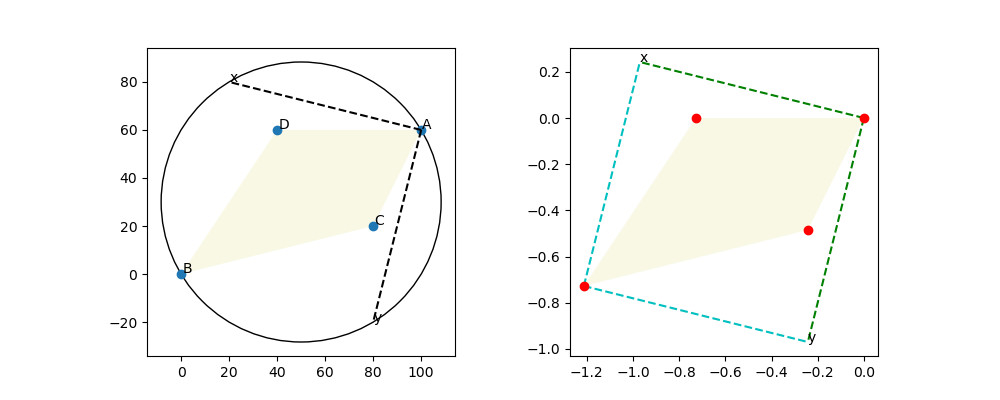

[0.11764706 0.52941176 0.70588235 0.17647059]


In [3]:
sources = np.array([(0, 0), (40, 60), (80, 20), (100, 60)])

indx, quad_hash = _make_quad(sources, [0, 1, 2, 3])
stars = sources[indx]
a, b, c, d = stars
norm = np.linalg.norm(b-a)
norm_axis = _get_axis(a, b)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].add_patch(plt.Polygon(stars[[0, 2, 1, 3]], facecolor='y', alpha=0.1))
ax[0].plot(*sources.T, 'o')
for i, name in zip(indx, ['A', 'B', 'C', 'D']):
    ax[0].annotate(name, sources[i]+0.5)
axis = np.array(norm_axis)*norm/np.sqrt(2)
ax[0].plot([a[0], axis[0][0]+a[0]], [a[1], axis[0][1]+a[1]], 'k--')
ax[0].annotate('x', (axis[0][0]+a[0], axis[0][1]+a[1]))
ax[0].plot([a[0], axis[1][0]+a[0]], [a[1], axis[1][1]+a[1]], 'k--')
ax[0].annotate('y', (axis[1][0]+a[0], axis[1][1]+a[1]))
ax[0].set_aspect('equal')
ax[0].add_patch(plt.Circle((a+b)/2, radius=norm/2, fill=False))

norm_stars = np.sqrt(2)*(stars-a)/norm
ax[1].add_patch(plt.Polygon(norm_stars[[0, 2, 1, 3]], facecolor='y', alpha=0.1))
ax[1].plot(*np.transpose([norm_stars[1], norm_axis[0]]), 'c--')
ax[1].annotate('x', norm_axis[0])
ax[1].plot(*np.transpose([norm_stars[1], norm_axis[1]]), 'c--')
ax[1].annotate('y', norm_axis[1])
ax[1].plot([0, norm_axis[0][0]], [0, norm_axis[0][1]], 'g--')
ax[1].plot([0, norm_axis[1][0]], [0, norm_axis[1][1]], 'g--')
ax[1].plot(*norm_stars.T, 'ro')
ax[1].set_aspect("equal")

print(quad_hash)

## Benchmarking

### _make_quad function

For _make_quad function, our timings are:
- Pure-python implementation: 120 µs ± 5.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
- Cython implementation: 

In [7]:
# benchmark quads creation
a = AstrometrySolver()
import time
for i in range(7):
    begin = time.time()
    quads = list(a._compute_quads(np.transpose([hd5980['x'][:50], hd5980['y'][:50]]), max_quads=10**i))
    logger.info('%i quads %.4f s', len(quads), time.time()-begin)

2022-03-26 11:21:35,624 astropop - DEBUG - Using random 1 combinations.  [2550347427]
2022-03-26 11:21:35,629 astropop - INFO - 1 quads 0.0062 s  [3263864062]
2022-03-26 11:21:35,632 astropop - DEBUG - Using random 10 combinations.  [2550347427]
2022-03-26 11:21:35,648 astropop - INFO - 10 quads 0.0170 s  [3263864062]
2022-03-26 11:21:35,650 astropop - DEBUG - Using random 100 combinations.  [2550347427]
2022-03-26 11:21:35,730 astropop - INFO - 100 quads 0.0809 s  [3263864062]
2022-03-26 11:21:35,733 astropop - DEBUG - Using random 1000 combinations.  [2550347427]
2022-03-26 11:21:36,031 astropop - INFO - 1000 quads 0.2988 s  [3263864062]
2022-03-26 11:21:36,031 astropop - DEBUG - Using random 10000 combinations.  [2550347427]
2022-03-26 11:21:37,278 astropop - INFO - 10000 quads 1.2465 s  [3263864062]
2022-03-26 11:21:37,278 astropop - DEBUG - Using random 100000 combinations.  [2550347427]
2022-03-26 11:21:49,783 astropop - INFO - 100000 quads 12.5044 s  [3263864062]
2022-03-26 11:2

In [8]:
# Pure-Python
x = np.array((20, 50, 30, 10))
y = np.array((15, 45, 12, 80))
indx = np.arange(4)
%timeit _make_quad(np.array(list(zip(x, y))), indx)

119 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Flipped image

If a image is flipped, the coordinates of the stars change to:
- $x_n = size_H-x_o$ if flipped horizontally.
- $y_n = size_V-y_o$ if flipped vertically.

In both of these flips, the axis $x$ and $y$ are swapped, so the respective coordinates of each star in the quad hash. As the coordinates are swapped and the symmetry breaking is done using $x$, the order of $C$ and $D$ stars may be swapped too.

In [9]:
x = np.array((20, 50, 30, 10))
y = np.array((15, 45, 12, 80))
indx = np.arange(4)
print(_make_quad(np.array(list(zip(x, y))), indx))
print(_make_quad(np.array(list(zip(100-x, y))), indx))
print(_make_quad(np.array(list(zip(x, 100-y))), indx))

(array([2, 3, 0, 1]), array([-0.04299363,  0.20382166,  0.76910828, -0.03503185]))
(array([2, 3, 1, 0]), array([-0.03503185,  0.76910828,  0.20382166, -0.04299363]))
(array([2, 3, 1, 0]), array([-0.03503185,  0.76910828,  0.20382166, -0.04299363]))


### Catalog Quads

Catalog return values of RA and DEC. Near the equator it seems ok to use directly these values to compute quads in the solution. However, going to poles the quads begin to deform and will not result in a good fitting.

To get better quads near poles, we need to use tangencial gnomonic projection relative to the center of the query or the field. This can be easily done using the built-in projection of WCS. We set the reference values of a simple WCS to the center of the field and use this WCS to convert world to pixel coordinates. The scale don't need to be precise, as we are working with float point coordinates.

In the figure bellow, we compare two fields near the celetial poles. The RA/DEC plots show very deformed asterisms. For comparison, it was added two perfect quads around the poles. Of course they don't look quads in the unprojected plots. Projecting it to gnomonic tangecial plane solves the problem, so we can use this method for our solution.

<IPython.core.display.Javascript object>


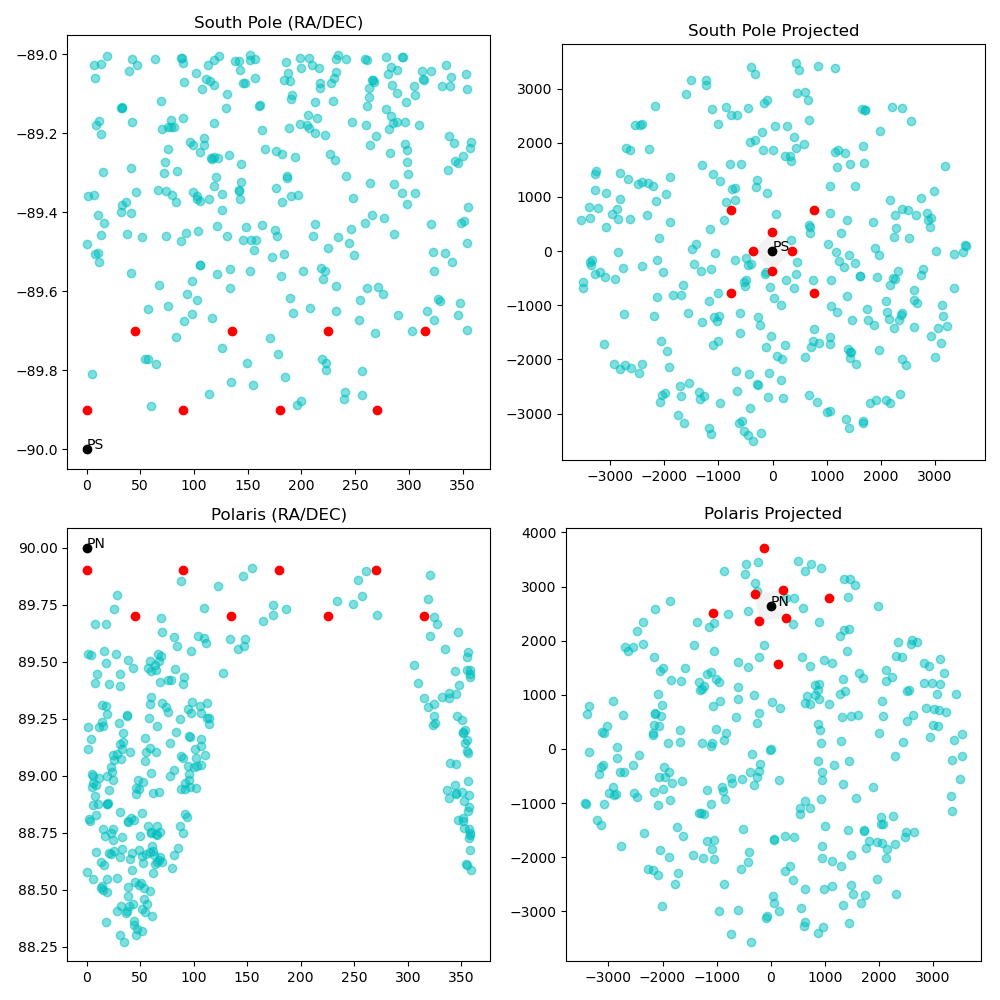

In [10]:
import twirl
from astropy.wcs import WCS
# Use WCS for fast projection ofthe catalog
# avoid distorded quads near poles

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# south pole
center = SkyCoord('00h00m00s -90d00m00s')
center = [center.ra.degree, center.dec.degree]
fov = 1.0
gaias = twirl.gaia_radecs(center, fov, limit=300)

gaia = SkyCoord(gaias, unit='deg')
pole = SkyCoord([(0, -90)], unit='deg')
pole_quad = SkyCoord([(0, -89.9), (90, -89.9), (180, -89.9), (270, -89.9),
                      (45, -89.7), (135, -89.7), (225, -89.7), (315, -89.7)], unit='deg')

# ra and dec plot
ax[0][0].plot(gaia.ra.degree, gaia.dec.degree, 'co', alpha=0.5)
ax[0][0].plot(pole.ra.degree, pole.dec.degree, 'ko')
ax[0][0].annotate('PS', (pole.ra.degree, pole.dec.degree))
ax[0][0].plot(pole_quad.ra.degree, pole_quad.dec.degree, 'ro')
ax[0][0].set_title('South Pole (RA/DEC)')

# projected
ax[0][1].plot(*tangential_projection(gaia, center).T, 'co', alpha=0.5)
ax[0][1].add_patch(plt.Polygon(tangential_projection(pole_quad, center)[:4], facecolor='k', alpha=0.05))
ax[0][1].plot(*tangential_projection(pole, center).T, 'ko')
ax[0][1].annotate('PS', tangential_projection(pole, center).T)
ax[0][1].plot(*tangential_projection(pole_quad, center).T, 'ro')
ax[0][1].set_aspect('equal')
ax[0][1].set_title('South Pole Projected')


# Polaris
center = SkyCoord('02h31m49s 89d15m50s')
center = [center.ra.degree, center.dec.degree]
fov = 1.0
gaias = twirl.gaia_radecs(center, fov, limit=300)

gaia = SkyCoord(gaias, unit='deg')
pole = SkyCoord([(0, 90)], unit='deg')
pole_quad = SkyCoord([(0, 89.9), (90, 89.9), (180, 89.9), (270, 89.9),
                      (45, 89.7), (135, 89.7), (225, 89.7), (315, 89.7)], unit='deg')

# ra and dec plot
ax[1][0].plot(gaia.ra.degree, gaia.dec.degree, 'co', alpha=0.5)
ax[1][0].plot(pole.ra.degree, pole.dec.degree, 'ko')
ax[1][0].annotate('PN', (pole.ra.degree, pole.dec.degree))
ax[1][0].plot(pole_quad.ra.degree, pole_quad.dec.degree, 'ro')
ax[1][0].set_title('Polaris (RA/DEC)')

# projected
ax[1][1].plot(*tangential_projection(gaia, center).T, 'co', alpha=0.5)
ax[1][1].add_patch(plt.Polygon(tangential_projection(pole_quad, center)[:4], facecolor='k', alpha=0.05))
ax[1][1].plot(*tangential_projection(pole, center).T, 'ko')
ax[1][1].annotate('PN', tangential_projection(pole, center).T)
ax[1][1].plot(*tangential_projection(pole_quad, center).T, 'ro')
ax[1][1].set_aspect('equal')
ax[1][1].set_title('Polaris Projected')

fig.tight_layout()

## Astrometry.net index files

Astrometry.net index files contains pre-computed quads for astrometric catalogs. Let's break down them and see how data is stored.

It seems that all index files contains:
- 14 extensions. Only the primary is named.
    - 0: primary, only information in header
      ```
      ENDIAN  = '04:03:02:01' / Endianness detector: u32 0x01020304 written           
              =               /  in the order it is stored in memory.          
      AN_FILE = 'QUAD    ' / This file lists, for each quad, its stars.               
      DIMQUADS=                    3 / Number of stars in a quad.                     
      NQUADS  =                 1728 / Number of quads.                               
      NSTARS  =                 1080 / Number of stars.                               
      SCALE_U =       0.581776417331 / Upper-bound index scale (radians).             
      SCALE_L =       0.407243492132 / Lower-bound index scale (radians).             
      INDEXID =                 4219 / Index unique ID.                               
      HEALPIX =                   -1 / Healpix of this index.                         
      HPNSIDE =                    0 / Nside of the healpixelization
      ```
    - 1: list of quads coordinates. Are 12-bytes strings, must be converted.
    - 2-10: kdtree codes
    - 11: kdtree star data., 3d-data, 4-bytes each coordinate
    - 13: tagalong (magnitude)